In [12]:
import numpy as np
import pandas as pd
import time
import random
from sortedcontainers import SortedList
import matplotlib.pyplot as plt

random.seed(17)

In [2]:
from dataclasses import dataclass
from typing import Optional


@dataclass
class AnonTrade:  # Market trade
    timestamp: int
    side: str
    size: float
    price: float


@dataclass
class Order:  # Our own placed order
    timestamp: int
    order_id: int
    side: str
    size: float
    price: float


@dataclass
class OwnTrade:  # Execution of own placed order
    timestamp: int
    trade_id: int
    order_id: int
    side: str
    size: float
    price: float


@dataclass
class OrderbookSnapshotUpdate:  # Orderbook tick snapshot
    timestamp: int
    asks: list[tuple]  # tuple[price, size]
    bids: list[tuple]


@dataclass
class MdUpdate:  # Data of a tick
    orderbook: Optional[OrderbookSnapshotUpdate] = None
    trades: Optional[list[AnonTrade]] = None

In [3]:
btc_trades = pd.read_csv("../../../Downloads/md/md/btcusdt_Binance_LinearPerpetual/trades.csv")
btc_lobs = pd.read_csv("../../../Downloads/md/md/btcusdt_Binance_LinearPerpetual/lobs.csv")

In [5]:
eth_trades = pd.read_csv("../../../Downloads/md/md/ethusdt_Binance_LinearPerpetual/trades.csv")
eth_lobs = pd.read_csv("../../../Downloads/md/md/ethusdt_Binance_LinearPerpetual/lobs.csv")

In [4]:
np_btc_trades = btc_trades.to_numpy()
np_btc_lobs = btc_lobs.to_numpy()

trade_columns = btc_trades.columns.to_numpy()
lobs_columns = btc_lobs.columns.to_numpy()

# column name to index in numpy array
btc_ti = {trade_columns[i]: i for i, col in enumerate(trade_columns)}
btc_li = {lobs_columns[i]: i for i, col in enumerate(lobs_columns)}

In [7]:
print(btc_trades.shape)
print(btc_lobs.shape)

print(np_btc_trades[0])
print(np_btc_trades[0][btc_ti['price']])
print(np_btc_lobs[0])
print(np_btc_lobs[0][btc_li[' exchange_ts']])

(5727714, 5)
(2541356, 42)
[1655942402624789714 1655942402623000000 'BID' 19977.5 0.001]
19977.5
[1.6559424e+18 1.6559424e+18 1.9977500e+04 7.9000000e-02 1.9977400e+04
 1.2381000e+01 1.9977800e+04 3.0000000e-03 1.9976700e+04 6.6000000e-02
 1.9977900e+04 3.0000000e-03 1.9976400e+04 5.0000000e-02 1.9978000e+04
 1.2830000e+00 1.9976100e+04 1.4600000e-01 1.9978500e+04 1.0000000e-03
 1.9976000e+04 2.0500000e-01 1.9979000e+04 6.1200000e-01 1.9975900e+04
 2.4600000e-01 1.9979200e+04 2.1600000e-01 1.9975800e+04 6.8600000e-01
 1.9980000e+04 1.1170000e+00 1.9975700e+04 4.4550000e+00 1.9980100e+04
 1.0000000e-02 1.9975600e+04 1.5290000e+00 1.9980200e+04 1.0000000e-02
 1.9975400e+04 1.6410000e+00]
1.655942402249e+18


In [8]:
def load_md_from_file(pref, trades, lobs, ti, li) -> list[MdUpdate]:
    # TODO: load actual md
    pref_ask_price = pref + 'ask_price_'
    pref_ask_size = pref + 'ask_vol_'
    pref_bid_price = pref + 'bid_price_'
    pref_bid_size = pref + 'bid_vol_'
    
    mds = []
    i_tr = 0
    
    start_sec = time.time()
    print('Started parsing csv files...')
    for i_lobs in range(lobs.shape[0]):
        d = lobs[i_lobs]
        asks = [(d[li[pref_ask_price + str(i)]], d[li[pref_ask_size + str(i)]]) for i in range(10)]
        bids = [(d[li[pref_bid_price + str(i)]], d[li[pref_bid_size + str(i)]]) for i in range(10)]
        book = OrderbookSnapshotUpdate(timestamp = d[li[' exchange_ts']], asks = asks, bids = bids)
        
        anon_trades = []        
        while i_tr < trades.shape[0] and trades[i_tr][ti['exchange_ts']] < lobs[i_lobs][li[' exchange_ts']]:
            d = trades[i_tr]
            at = AnonTrade(timestamp=d[ti['exchange_ts']], side=d[ti['aggro_side']].lower(), 
                           size=d[ti['size']], price=d[ti['price']])    
            anon_trades.append(at)

            i_tr += 1
            if i_tr % 500000 == 0:
                print('Trade progress: %d, %.2f%%' % (i_tr, i_tr / trades.shape[0] * 100))
        
        mds.append(MdUpdate(orderbook = book, trades = anon_trades))
        
        if i_lobs % 500000 == 0:
            print('Lobs progress: %d, %.2f%%' % (i_lobs, i_lobs / lobs.shape[0] * 100))
            
    print('Finished in %d seconds' % (time.time() - start_sec))
    return mds
                 

loaded_md = load_md_from_file('btcusdt:Binance:LinearPerpetual_', np_btc_trades, np_btc_lobs, btc_ti, btc_li)

Started parsing csv files...
Lobs progress: 0, 0.00%
Trade progress: 500000, 8.73%
Trade progress: 1000000, 17.46%
Lobs progress: 500000, 19.67%
Trade progress: 1500000, 26.19%
Lobs progress: 1000000, 39.35%
Trade progress: 2000000, 34.92%
Trade progress: 2500000, 43.65%
Trade progress: 3000000, 52.38%
Lobs progress: 1500000, 59.02%
Trade progress: 3500000, 61.11%
Trade progress: 4000000, 69.84%
Lobs progress: 2000000, 78.70%
Trade progress: 4500000, 78.57%
Trade progress: 5000000, 87.29%
Trade progress: 5500000, 96.02%
Lobs progress: 2500000, 98.37%
Finished in 113 seconds


In [15]:
class Strategy:
    def __init__(self, max_position: float) -> None:
        self.max_position = max_position
        self.position = 0
        self.cur_balance = 0
        self.total_executed_trades = 0
        self.total_canceled_trades = 0
        
        self.t0_cancel = 10 * 1000 * 1000 * 1000 # 10,000 seconds
        self.active_positions = SortedList()
        self.order2time = {}
        
        self.iteration = []
        self.pnl = []
        
    
    def get_best_ask(self, md):
        return md.orderbook.asks[0][0]
    
    
    def get_best_bid(self, md):
        return md.orderbook.bids[0][0]
    
    
    def get_PNL(self, md):
        price = (self.get_best_ask(md) + self.get_best_bid(md)) / 2
        
        return price * self.position + self.cur_balance
    
    
    def smart_AI(self, md):
        is_ask = random.randint(0, 1)
        if self.position > self.max_position:
            is_ask = 1
        if self.position < -self.max_position:
            is_ask = 0
            
        if is_ask:
            side = 'ask'
            size = 0.001
            price = self.get_best_ask(md)
        else:
            side = 'bid'
            size = 0.001
            price = self.get_best_bid(md)
        
        return side, size, price
    
    
    def get_time(self, md):
        return md.orderbook.timestamp
    
    
    def print_stats(self, counter, md):
        self.iteration.append(counter)
        self.pnl.append(self.get_PNL(md))
        
        if counter % 10000 == 0:
            print('Iteration %d - executed %d, canceled %d, position: %0.4f, balance: %.5f, PNL: %.3f' % 
                  (counter, self.total_executed_trades, self.total_canceled_trades, 
                   self.position, self.cur_balance, self.get_PNL(md)))
        return counter + 1
    
    
    def plot(self):
        plt.title("PNL over iterations (3 years)")
        plt.plot(self.iteration, self.pnl, '.g')
        plt.show()
        
    
    def run(self, sim: "Sim"):
        counter = 0
        while True:
            try:
                md, executed = sim.tick()
                if md == None:
                    print('End of data!')
                    break
                
                # calculate statistics
                self.total_executed_trades += len(executed)
                for order in executed:
                    if order.side == 'ask':
                        self.position -= order.size
                        self.cur_balance += order.size * order.price
                    if order.side == 'bid':
                        self.position += order.size
                        self.cur_balance -= order.size * order.price
                    
                    active = (self.order2time[order.order_id], order.order_id)
                    self.active_positions.remove(active)
                
                # place order
                side, size, price = self.smart_AI(md)
                order_id = sim.place_order(side, size, price)
                
                # record it
                self.active_positions.add((self.get_time(md), order_id))
                self.order2time[order_id] = self.get_time(md)
                
                # cancel old orders
                while len(self.active_positions) and self.active_positions[0][0] + self.t0_cancel < self.get_time(md):
                    timestamp, order_id = self.active_positions.pop(0)
                    success = sim.cancel_order(order_id)
                    if success:
                        self.total_canceled_trades += 1
                    
                counter = self.print_stats(counter, md)
            except StopIteration:
                break

In [18]:
class Sim:
    def __init__(self, execution_latency: float, md_latency: float, loaded_md: list[MdUpdate]) -> None:
        self.md = iter(loaded_md)
        self.cur_time = 0
        self.execution_latency = execution_latency
        self.md_latency = md_latency
        
        self.unique_id = 1
        self.queue = {}
        self.arrived_orders = {}
        self.inside_book = {}
        self.executed_queue = []

    
    def gen_id(self):
        ans = self.unique_id
        self.unique_id += 1
        return ans
        
        
    def tick(self) -> MdUpdate:
        md = next(self.md, None)
        if md == None: return None, None
        
        self.cur_time = md.orderbook.timestamp
        
        self.prepare_orders()
        self.execute_orders(md)
        executed = self.prepare_trades()
        
        return md, executed

    
    def prepare_orders(self): # wait for execution_latency to accept the order
        processed_ids = []
        for order in self.queue.values():
            if order.timestamp + self.execution_latency <= self.cur_time:
                self.arrived_orders[order.order_id] = order
                processed_ids.append(order.order_id)

        for order_id in processed_ids:     
            self.queue.pop(order_id)
            
    
    def prepare_trades(self): # wait for md_latency to return trades
        executed = []
        new_queue = []
        
        for trade in self.executed_queue:
            if trade.timestamp + self.md_latency <= self.cur_time:
                executed.append(trade)
            else:
                new_queue.append(trade)
        
        self.executed_queue = new_queue
        return executed

        
    def matches_book(self, order, md):
        book = md.orderbook
        if order.side == 'bid': # buying
            if book.asks[0][0] <= order.price:
                return (True, book.asks[0][0])
        if order.side == 'ask':
            if book.bids[0][0] >= order.price:
                return (True, book.bids[0][0])
        return (False, -1)
    
    
    def matches_trade_flow(self, order, condensed_trades):
        asks, bids = condensed_trades
        if order.side == 'bid':
            return bids[0] and bids[1] <= order.price
        if order.side == 'ask':
            return asks[0] and asks[1] >= order.price
        
    
    def get_condensed_trades(self, md):
        mn_bid, mx_ask = 0, 0
        exist_bid, exist_ask = False, False
        
        for tr in md.trades:
            if tr.side == 'bid':
                if not exist_bid or tr.price < mn_bid:
                    mn_bid = tr.price
                    exist_bid = True
            if tr.side == 'ask':
                if not exist_ask or tr.price > mx_ask:
                    mx_ask = tr.price
                    exist_ask = True
            
        return ((exist_ask, mx_ask), (exist_bid, mn_bid))
    
    
    def execute_orders(self, md):
        # Limit orders
        condensed_trades = self.get_condensed_trades(md)
        processed_ids = []
        
        for order in self.inside_book.values():
            if self.matches_trade_flow(order, condensed_trades) or self.matches_book(order, md):
                self.executed_queue.append(OwnTrade(self.cur_time, self.gen_id(), order.order_id, 
                                                    order.side, order.size, order.price))
                processed_ids.append(order.order_id)

        for order_id in processed_ids:        
            self.inside_book.pop(order_id)

        # Market orders
        for order in self.arrived_orders.values():
            matched, price = self.matches_book(order, md)
            if matched:
                self.executed_queue.append(OwnTrade(self.cur_time, self.gen_id(), order.order_id, 
                                                    order.side, order.size, price))
            else:
                self.inside_book[order.order_id] = order
        self.arrived_orders = {}

    
    def place_order(self, side, size, price):
        order_id = self.gen_id()
        self.queue[order_id] = Order(self.cur_time, order_id, side, size, price)
        return order_id

        
    def cancel_order(self, order_id):
        canceled = False
        if order_id in self.queue:
            self.queue.pop(order_id)
            canceled = True
        if order_id in self.arrived_orders:
            self.arrived_orders.pop(order_id)
            canceled = True
        if order_id in self.inside_book:
            self.inside_book.pop(order_id)
            canceled = True
        return canceled

In [19]:
strategy = Strategy(10)
sim = Sim(10, 10, loaded_md)
strategy.run(sim)

Iteration 0 - executed 0, canceled 0, position: 0.0000, balance: 0.00000, PNL: 0.000
Iteration 10000 - executed 9999, canceled 0, position: -0.0490, balance: 986.00430, PNL: 6.041
Iteration 20000 - executed 19999, canceled 0, position: -0.1990, balance: 3997.25250, PNL: 4.905
Iteration 30000 - executed 30000, canceled 0, position: -0.2640, balance: 5307.99020, PNL: -17.431
Iteration 40000 - executed 39999, canceled 0, position: -0.4250, balance: 8555.92620, PNL: -6.188
Iteration 50000 - executed 49999, canceled 0, position: -0.4230, balance: 8537.66060, PNL: -61.126
Iteration 60000 - executed 59999, canceled 0, position: -0.3010, balance: 6063.75230, PNL: -35.667
Iteration 70000 - executed 69999, canceled 0, position: -0.4250, balance: 8577.49630, PNL: -58.737
Iteration 80000 - executed 79999, canceled 0, position: -0.3550, balance: 7157.69330, PNL: -45.913
Iteration 90000 - executed 89999, canceled 0, position: -0.2430, balance: 4888.92790, PNL: -70.350
Iteration 100000 - executed 999

Iteration 830000 - executed 829999, canceled 0, position: 0.3750, balance: -7577.23120, PNL: 102.750
Iteration 840000 - executed 839999, canceled 0, position: 0.3050, balance: -6145.37700, PNL: 88.686
Iteration 850000 - executed 849999, canceled 0, position: 0.2490, balance: -5000.05780, PNL: 90.336
Iteration 860000 - executed 859999, canceled 0, position: 0.2310, balance: -4625.91640, PNL: 113.961
Iteration 870000 - executed 869999, canceled 0, position: 0.3070, balance: -6186.25020, PNL: 131.794
Iteration 880000 - executed 879999, canceled 0, position: 0.3470, balance: -7009.50890, PNL: 147.835
Iteration 890000 - executed 889999, canceled 0, position: 0.3350, balance: -6762.69540, PNL: 122.342
Iteration 900000 - executed 899999, canceled 0, position: 0.2510, balance: -5034.36700, PNL: 133.961
Iteration 910000 - executed 909999, canceled 0, position: 0.3170, balance: -6391.37200, PNL: 119.047
Iteration 920000 - executed 919999, canceled 0, position: 0.4610, balance: -9341.88600, PNL: 

Iteration 1630000 - executed 1629999, canceled 0, position: 0.8170, balance: -16634.80260, PNL: 73.297
Iteration 1640000 - executed 1639999, canceled 0, position: 0.7570, balance: -15406.92120, PNL: 50.300
Iteration 1650000 - executed 1649999, canceled 0, position: 0.8090, balance: -16460.54940, PNL: -19.283
Iteration 1660000 - executed 1659999, canceled 0, position: 0.7590, balance: -15442.21570, PNL: -8.065
Iteration 1670000 - executed 1669999, canceled 0, position: 1.0030, balance: -20403.12860, PNL: -16.903
Iteration 1680000 - executed 1679999, canceled 0, position: 0.9490, balance: -19304.71240, PNL: -6.275
Iteration 1690000 - executed 1689999, canceled 0, position: 1.1310, balance: -23010.51440, PNL: 24.393
Iteration 1700000 - executed 1699999, canceled 0, position: 1.1250, balance: -22886.97320, PNL: -30.067
Iteration 1710000 - executed 1709999, canceled 0, position: 1.1870, balance: -24143.91820, PNL: -82.360
Iteration 1720000 - executed 1719999, canceled 0, position: 1.0430, b

Iteration 2430000 - executed 2429999, canceled 0, position: 0.1390, balance: -2309.44290, PNL: 609.995
Iteration 2440000 - executed 2439999, canceled 0, position: 0.1350, balance: -2224.41610, PNL: 608.566
Iteration 2450000 - executed 2449999, canceled 0, position: 0.3190, balance: -6093.52220, PNL: 618.413
Iteration 2460000 - executed 2459999, canceled 0, position: 0.4270, balance: -8364.91030, PNL: 623.931
Iteration 2470000 - executed 2469999, canceled 0, position: 0.4350, balance: -8534.71100, PNL: 614.013
Iteration 2480000 - executed 2480000, canceled 0, position: 0.5520, balance: -11008.36730, PNL: 664.418
Iteration 2490000 - executed 2489999, canceled 0, position: 0.6450, balance: -12972.17120, PNL: 672.578
Iteration 2500000 - executed 2499999, canceled 0, position: 0.7310, balance: -14792.24150, PNL: 638.547
Iteration 2510000 - executed 2509999, canceled 0, position: 0.7030, balance: -14199.97180, PNL: 652.977
Iteration 2520000 - executed 2519999, canceled 0, position: 0.6290, b

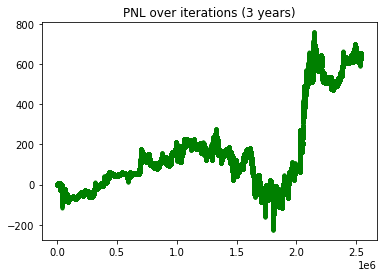

In [20]:
strategy.plot()